In [1]:
import os
import time
import json
import itertools

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from numpy import random
from scipy.optimize import fsolve

from paretoset import paretoset
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.indicators.gd import GD
from pymoo.indicators.hv import HV

import importlib

In [2]:
# -------------- PART 0: CHOOSE CIRCUIT AND SET UP FOLDER --------------

# Choose circuit
circuit = "posneg"

# Import circuit config file
config = importlib.import_module(circuit)

# Define the subfolder name
folder_name = f"NGSA2_{circuit}"

# Create folder if not yet exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Jump to folder
os.chdir(folder_name)

# Prompt new folder name
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/nt625/Documents/GitHub/SA/Genetic Algorithms for Multi-Objective Optimization/Nam/PosNeg/NGSA2_posneg


In [10]:
# -------------- PART 0b: DEFINE DYNAMICAL SYSTEM --------------

# dx/dt
Equ1 = config.Equ1

# dy/dt
Equ2 = config.Equ2
    
# Define function to evaluate vector field
def Equs(P, t, params):
    x = P[0]
    y = P[1]
    beta_x = params[0]
    beta_y = params[1]
    n      = params[2]
    val0 = Equ1(x, y, beta_x, n)
    val1 = Equ2(x, y, beta_y, n)
    return np.array([val0, val1])

# Define values
t = 0.0
numss=1

In [4]:
# -------------- PART 0c: DEFINE SENSITIVITY FUNCTIONS --------------

# Define analytical sensitivity expressions
S_betax_xss_analytic = config.S_betax_xss_analytic
S_betax_yss_analytic = config.S_betay_xss_analytic
S_betay_xss_analytic = config.S_betay_xss_analytic
S_betay_yss_analytic = config.S_betay_yss_analytic
S_n_xss_analytic = config.S_n_xss_analytic
S_n_yss_analytic = config.S_n_yss_analytic

In [5]:
# -------------- PART 0d: CHOOSE SENSITIVITY FUNCTIONS --------------

# Print prompt
print("""
We have the following sensitivity functions:
0. |S_betax_xss|
1. |S_betax_yss|
2. |S_betay_xss|
3. |S_betay_yss|
4. |S_n_xss|
5. |S_n_yss|
""")

# Choose pair of functions
choice1 = int(input("Please select first option number:"))
choice2 = int(input("Please select second option number:"))

def senpair(choice1, choice2):
    # Map each label to its corresponding analytical function
    sensitivity_funcs = {
        "|S_betax_xss|": S_betax_xss_analytic,
        "|S_betax_yss|": S_betax_yss_analytic,
        "|S_betay_xss|": S_betay_xss_analytic,
        "|S_betay_yss|": S_betay_yss_analytic,
        "|S_n_xss|":     S_n_xss_analytic,
        "|S_n_yss|":     S_n_yss_analytic
    }

    # Labels in consistent order
    sensitivity_labels = list(sensitivity_funcs.keys())

    # Select based on user choice
    label1, func1 = sensitivity_labels[choice1], sensitivity_funcs[sensitivity_labels[choice1]]
    label2, func2 = sensitivity_labels[choice2], sensitivity_funcs[sensitivity_labels[choice2]]

    # Return both the labels and the function handles
    return label1, func1, label2, func2


We have the following sensitivity functions:
0. |S_betax_xss|
1. |S_betax_yss|
2. |S_betay_xss|
3. |S_betay_yss|
4. |S_n_xss|
5. |S_n_yss|



In [6]:
# -------------- PART 0e: CHANGING DIRECTORIES --------------

# Define the subfolder name
subfolder_name = f"NSGA2_sensfuncs_{choice1}_and_{choice2}"

# Create folder if not yet exist
if not os.path.exists(subfolder_name):
    os.makedirs(subfolder_name)

# Jump to folder
os.chdir(subfolder_name)

# Prompt new folder name
print(f"Current working directory: {os.getcwd()}")

if not os.path.exists('data'):
    os.makedirs('data')

Current working directory: /Users/nt625/Documents/GitHub/SA/Genetic Algorithms for Multi-Objective Optimization/Nam/PosNeg/NGSA2_posneg/NSGA2_sensfuncs_0_and_1


In [7]:
# DEFINE FUNCTION THAT SOLVES FOR STEADY STATES XSS AND YSS GIVEN SOME INITIAL GUESS
def ssfinder(beta_x_val,beta_y_val,n_val):

    # If we have one steady state
    if numss == 1: 
        
        # Define initial guesses
        InitGuesses = config.generate_initial_guesses(beta_x_val, beta_y_val)
        
        # Define array of parameters
        params = np.array([beta_x_val, beta_y_val, n_val])
        
        # For each until you get one that gives a solution or you exhaust the list
        for InitGuess in InitGuesses:
    
            # Get solution details
            output, infodict, intflag, _ = fsolve(Equs, InitGuess, args=(t, params), xtol=1e-12, full_output=True)
            xss, yss = output
            fvec = infodict['fvec'] 
    
            # Check if stable attractor point
            delta = 1e-8
            dEqudx = (Equs([xss+delta,yss], t, params)-Equs([xss,yss], t, params))/delta
            dEqudy = (Equs([xss,yss+delta], t, params)-Equs([xss,yss], t, params))/delta
            jac = np.transpose(np.vstack((dEqudx,dEqudy)))
            eig = np.linalg.eig(jac)[0]
            instablility = np.any(np.real(eig) >= 0)
    
            # Check if it is sufficiently large, has small residual, and successfully converges
            if xss > 0.04 and yss > 0.04 and np.linalg.norm(fvec) < 1e-10 and intflag == 1 and instablility==False:
                # If so, it is a valid solution and we return it
                return xss, yss
    
        # If no valid solutions are found after trying all initial guesses
        return float('nan'), float('nan')


In [8]:
class Sensitivity(ElementwiseProblem):
    def __init__(self, choice1, choice2):
        super().__init__(
            n_var=3,  # beta_x, beta_y, n
            n_obj=2,  # two sensitivities
            n_constr=0,
            xl=np.array([0.01, 0.01, 0.01]),
            xu=np.array([50.0, 50.0, 10.0]),
        )

        # Select functions once
        _, f1, _, f2 = senpair(choice1, choice2)
        self.f1 = f1
        self.f2 = f2

    def _evaluate(self, x, out, *args, **kwargs):
        
        beta_x, beta_y, n = x
        xss, yss = ssfinder(beta_x, beta_y, n)

        if np.isnan(xss) or np.isnan(yss):
            out["F"] = [1e5, 1e5]  #### Penalize invalid solutions

        else:
            # Direct evaluation — assumes valid steady states
            S1 = self.f1(xss, yss, beta_x, beta_y, n)
            S2 = self.f2(xss, yss, beta_x, beta_y, n)

            # Ensure scalar floats
            S1 = float(np.asarray(S1))
            S2 = float(np.asarray(S2))

            out["F"] = [
                S1,
                S2
            ]

Run for varying population sizes and fixed number of generations

In [11]:
# --- Parameter sweeps ---
popsize_list = np.exp(np.linspace(np.log(1), np.log(500), num=6)).astype(int)
gens_list = np.exp(np.linspace(np.log(1), np.log(100), num=6)).astype(int)

# Storage structure:
# ┌───────────────────────────────────────────────┐
# │                 Generation (j)                │
# │            gen_1     gen_2     gen_3   ...    │
# ├───────────────────────────────────────────────┤
# │ pop_1     [None]    [None]    [None]   ...    │
# │ pop_2     [None]    [None]    [None]   ...    │
# │ pop_3     [None]    [None]    [None]   ...    │
# │   ...       ...       ...       ...           │
# └───────────────────────────────────────────────┘
all_F = [[None for _ in gens_list] for _ in popsize_list]
all_X = [[None for _ in gens_list] for _ in popsize_list]
all_time = np.zeros((len(popsize_list), len(gens_list)))
all_size = np.zeros((len(popsize_list), len(gens_list)), dtype=int)

# --- Optimization loops ---
for i, popsize in enumerate(popsize_list):
    for j, gens in enumerate(gens_list):

        algorithm = NSGA2(pop_size=int(popsize))

        res = minimize(
            Sensitivity(choice1,choice2),        # your optimization problem
            algorithm,            # algorithm instance
            ('n_gen', int(gens)), # number of generations as stopping criterion
            seed=1,               # reproducibility
            verbose=False)

        # Store results in grid form
        all_F[i][j] = res.F
        all_X[i][j] = res.X
        all_time[i, j] = res.exec_time
        all_size[i, j] = res.F.shape[0]

        print(f"Finished run: population = {popsize:5d}, generations = {gens:4d}  (time: {res.exec_time:.2f}s)")

# Our final all_F and all_X structures
# ┌───────────────────────────────────────────────┐
# │                 Generation (j)                │
# │         gen_1     gen_2     gen_3   ...       │
# ├───────────────────────────────────────────────┤
# │ pop_1  [F[0][0]] [F[0][1]] [F[0][2]] ...      │
# │ pop_2  [F[1][0]] [F[1][1]] [F[1][2]] ...      │
# │ pop_3  [F[2][0]] [F[2][1]] [F[2][2]] ...      │
# │  ...       ...       ...       ...            │
# └───────────────────────────────────────────────┘

# Conver to numpy array
all_F_np = np.array(all_F, dtype=object)
all_X_np = np.array(all_X, dtype=object)

Finished run: population =     1, generations =    1  (time: 0.01s)
Finished run: population =     1, generations =    2  (time: 0.00s)
Finished run: population =     1, generations =    6  (time: 0.01s)
Finished run: population =     1, generations =   15  (time: 0.01s)
Finished run: population =     1, generations =   39  (time: 0.02s)
Finished run: population =     1, generations =  100  (time: 0.05s)
Finished run: population =     3, generations =    1  (time: 0.00s)
Finished run: population =     3, generations =    2  (time: 0.00s)
Finished run: population =     3, generations =    6  (time: 0.00s)
Finished run: population =     3, generations =   15  (time: 0.01s)
Finished run: population =     3, generations =   39  (time: 0.03s)


/Users/nt625/Documents/GitHub/SA/Genetic Algorithms for Multi-Objective Optimization/Nam/PosNeg/posneg.py:8: RuntimeWarning: invalid value encountered in scalar power
  return beta_y * x**n / (1 + x**n) - y


Finished run: population =     3, generations =  100  (time: 0.11s)
Finished run: population =    12, generations =    1  (time: 0.00s)
Finished run: population =    12, generations =    2  (time: 0.00s)
Finished run: population =    12, generations =    6  (time: 0.01s)
Finished run: population =    12, generations =   15  (time: 0.02s)
Finished run: population =    12, generations =   39  (time: 0.06s)


/Users/nt625/Documents/GitHub/SA/Genetic Algorithms for Multi-Objective Optimization/Nam/PosNeg/posneg.py:6: RuntimeWarning: invalid value encountered in scalar power
  return beta_x / (1 + y**n) - x


Finished run: population =    12, generations =  100  (time: 0.18s)
Finished run: population =    41, generations =    1  (time: 0.00s)
Finished run: population =    41, generations =    2  (time: 0.01s)
Finished run: population =    41, generations =    6  (time: 0.03s)
Finished run: population =    41, generations =   15  (time: 0.07s)
Finished run: population =    41, generations =   39  (time: 0.20s)
Finished run: population =    41, generations =  100  (time: 0.51s)
Finished run: population =   144, generations =    1  (time: 0.01s)
Finished run: population =   144, generations =    2  (time: 0.03s)
Finished run: population =   144, generations =    6  (time: 0.08s)
Finished run: population =   144, generations =   15  (time: 0.24s)
Finished run: population =   144, generations =   39  (time: 0.63s)
Finished run: population =   144, generations =  100  (time: 1.68s)
Finished run: population =   499, generations =    1  (time: 0.05s)
Finished run: population =   499, generations = 

Analysis: evolving Pareto fronts with population size (column wise evolution)

In [12]:
# Create storage for evolving pareto fronts across population sizes for each generation
Storage_EvolvingParetos_Popsize = np.empty((len(popsize_list), len(gens_list)), dtype=object)
Storage_EvolvingParams_Popsize  = np.empty((len(popsize_list), len(gens_list)), dtype=object)

# Loop through generations column-wise
for columnnum, gens in enumerate(gens_list):

    # Get the data for this generation across all population sizes
    Fcolumn = all_F_np[:, columnnum] 
    Xcolumn = all_X_np[:, columnnum]

    # Column vectors to store sequence of Pareto front & parameter coordinates
    pareto_front_sequence = np.empty(Fcolumn.size, dtype=object)
    pareto_param_sequence = np.empty(Xcolumn.size, dtype=object)

    # Loop through populations
    for rownum, popsize in enumerate(popsize_list):
        
        # Initialize empty accumulators for this population size
        AllParetoFrontsUpToCurrentPop = np.empty((0, 2))  # Initialize an empty array
        AllParetoParamsUpToCurrentPop = np.empty((0, 3))  # Initialize an empty array

        # Accumulate data from the first run up to the current run
        for ind in range(rownum + 1):

            CurrentParetoFront = Fcolumn[ind]
            AllParetoFrontsUpToCurrentPop = np.vstack((AllParetoFrontsUpToCurrentPop, CurrentParetoFront))

            CurrentParetoParam = Xcolumn[ind]
            AllParetoParamsUpToCurrentPop = np.vstack((AllParetoParamsUpToCurrentPop, CurrentParetoParam))

        # Compute Pareto-optimal points
        mask = paretoset(AllParetoFrontsUpToCurrentPop, sense=["min", "min"])
        filteredfront = AllParetoFrontsUpToCurrentPop[mask]
        filteredparam = AllParetoParamsUpToCurrentPop[mask]

        # Store Pareto front and pareto parameters for this row
        pareto_front_sequence[rownum] = filteredfront
        pareto_param_sequence[rownum] = filteredparam

    # Store the full column sequence for this generation
    Storage_EvolvingParetos_Popsize[:,columnnum] = pareto_front_sequence
    Storage_EvolvingParams_Popsize[:,columnnum]  = pareto_param_sequence

In [13]:
# Import grid search data
gridsearchdata = np.load('../../Data_PositiveNegative_SensitivityPairsParetos.npz', allow_pickle=True)

# All possible unordered sensitivity function pairs (0–5)
all_pairs = list(itertools.combinations(range(6), 2))

def get_pareto_key(choice1, choice2):
    pair = tuple(sorted((choice1, choice2)))   # ensure order doesn’t matter
    idx = all_pairs.index(pair) + 1            # +1 since keys start from 1
    return f"paretoset_SensPair{idx}"

# Example: use your chosen sensitivity indices
key = get_pareto_key(choice1, choice2)

# Retrieve the dataset using the correct variable name
selected_griddata = gridsearchdata[key]

print(f"Selected grid search data for {key}:")
print(selected_griddata)

Selected grid search data for paretoset_SensPair1:
[[9.99998106e-01 2.34470555e-07]
 [9.99998121e-01 2.33997252e-07]
 [9.99998131e-01 2.32299045e-07]
 ...
 [1.49632539e-02 1.00373215e-01]
 [1.48523262e-02 1.00380144e-01]
 [1.03551183e-02 1.00385446e-01]]


In [15]:
from pymoo.indicators.igd import IGD

In [16]:
# Compute Generational Distance (GD) grid across population × generation
IGDs = np.full(Storage_EvolvingParetos_Popsize.shape, np.nan)  # prefill with NaN

# Define indicator once using the reference front
ind = IGD(selected_griddata)

for col, gens in enumerate(gens_list):             # loop over generations
    for row, popsize in enumerate(popsize_list):   # loop over population sizes
        pf = Storage_EvolvingParetos_Popsize[row, col]  # get Pareto front
        IGDs[row, col] = ind(pf)        # evaluate vs reference front

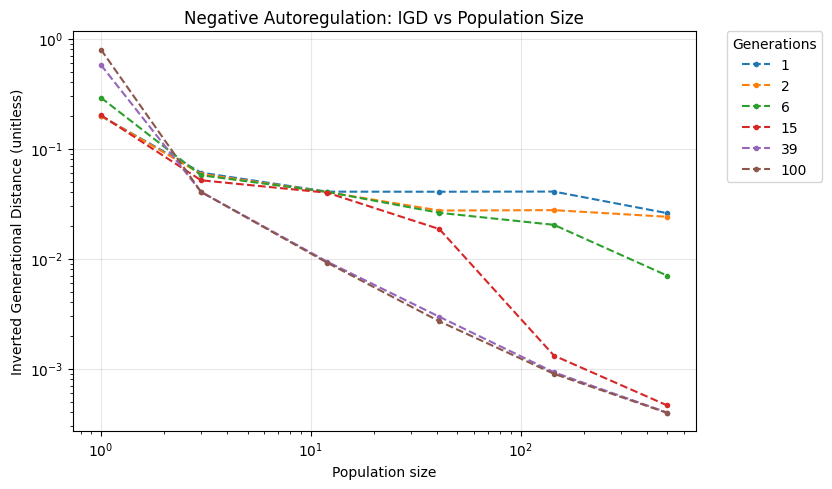

In [17]:
# --- Plot Generational Distance for each generation column ---
plt.figure(figsize=(10, 5))

# Loop over each column (generation)
for col, gens in enumerate(gens_list):
    plt.plot(
        popsize_list, 
        IGDs[:, col], 
        marker='.', 
        linestyle='--', 
        label=f'{gens}'
    )

plt.xlabel("Population size")
plt.ylabel("Inverted Generational Distance (unitless)")
plt.yscale('log')
plt.xscale('log')
plt.title("Negative Autoregulation: IGD vs Population Size")
plt.grid(alpha=0.3)

# --- Legend outside on the right ---
plt.legend(
    title="Generations",
    bbox_to_anchor=(1.05, 1),   # (x, y) position — push to the right
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on the right for legend
plt.show()

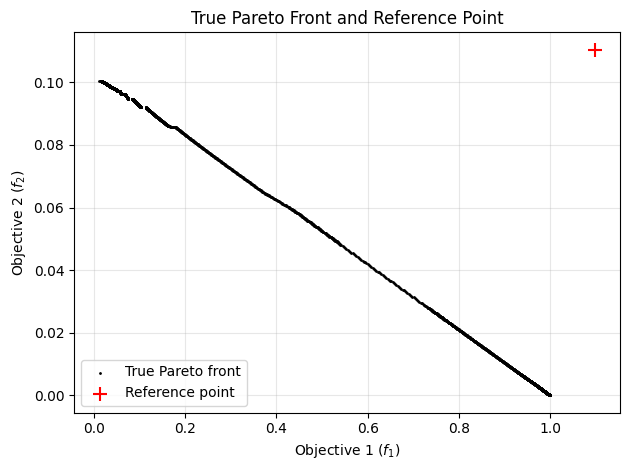

In [18]:
# --- Reference point based on true Pareto front (t) ---
buffer = 0.10  # 10% buffer beyond true front bounds
t_min = selected_griddata.min(axis=0)
t_max = selected_griddata.max(axis=0)
ref_point = t_max + buffer * (t_max - t_min)

plt.figure()

# --- True Pareto front ---
plt.scatter(
    selected_griddata[:,0],
    selected_griddata[:,1],
    color='black',
    label='True Pareto front',
    s=1,
    zorder=3
)

# --- Reference point ---
plt.scatter(
    ref_point[0],
    ref_point[1],
    color='red',
    marker='+',
    s=100,
    label='Reference point',
    zorder=4
)

plt.xlabel("Objective 1 ($f_1$)")
plt.ylabel("Objective 2 ($f_2$)")
plt.title("True Pareto Front and Reference Point")
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
ind = HV(ref_point=ref_point)
HV_true = float(ind(selected_griddata))

# --- Initialize storage ---
HV_grid = np.full(Storage_EvolvingParetos_Popsize.shape, np.nan)

# --- Compute HV for each cell ---
for i in range(Storage_EvolvingParetos_Popsize.shape[0]):      # population
    for j in range(Storage_EvolvingParetos_Popsize.shape[1]):  # generations
        
        pf = Storage_EvolvingParetos_Popsize[i, j]
        hv_val = float(ind(pf))
        HV_grid[i, j] = hv_val

print("Reference point:", ref_point)
print(f"True front HV: {HV_true:.6f}")
print("HV grid shape:", HV_grid.shape)

Reference point: [1.09896449 0.11042399]
True front HV: 0.069344
HV grid shape: (6, 6)


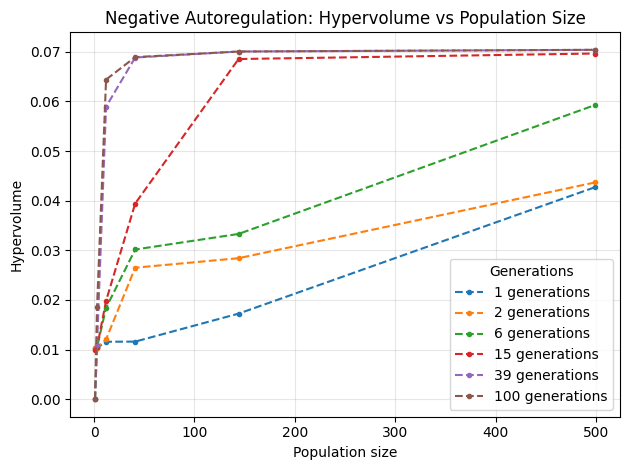

In [29]:
# --- Plot Hypervolume for each generation column ---
plt.figure()

for col, gens in enumerate(gens_list):
    plt.plot(
        popsize_list,
        HV_grid[:, col],
        marker='.',
        linestyle='--',
        label=f'{gens} generations'
    )

plt.xlabel("Population size")
plt.ylabel("Hypervolume")
# plt.xscale('log')
# plt.yscale('log')
plt.title("Negative Autoregulation: Hypervolume vs Population Size")
plt.legend(title="Generations", loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()